# Project Details
State notebook purpose here

### Imports
Import libraries and write settings here.

In [11]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import time
import warnings
warnings.filterwarnings('ignore')
import pickle

from sklearn import model_selection

In [12]:
modelFolder = '/Users/vk/Desktop/SchoolAndResearch/INSIGHT/HFT/models/ORIGINAL/'

# Get Data


In [13]:
data = pd.read_csv('/Users/vk/Desktop/SchoolAndResearch/INSIGHT/HFT/data/StockTrainData.csv')

features = ['high', 'low', 'average', 'volume', 'numberOfTrades', 'open',  'close', 'momentum_roc', 
            'momentum_rsi', 'momentum_stoch', 'trend_macd']


# Separating out the features
rollingData = data.filter(features)

#  if no trades prior minute, fill with previous row on all columns except volume/number of trades


rollingData = rollingData.fillna(method='ffill')
rollingDataDiff = rollingData.pct_change()

rollingDataDiff.replace([np.inf, -np.inf, np.nan], 0.000001,inplace=True)

tr_close = rollingDataDiff['close']
tr_direction = (tr_close > tr_close.shift()).astype(int)
rollingDataDiff['target'] = tr_direction.shift(-1).fillna(0).astype(int)




In [14]:
X = rollingDataDiff.iloc[:,:-1]
y = rollingDataDiff['target']

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.70,test_size=0.30, random_state=21)



# Descriptive Analysis


# Create Model

## Logistic Regression

0.6205128205128205


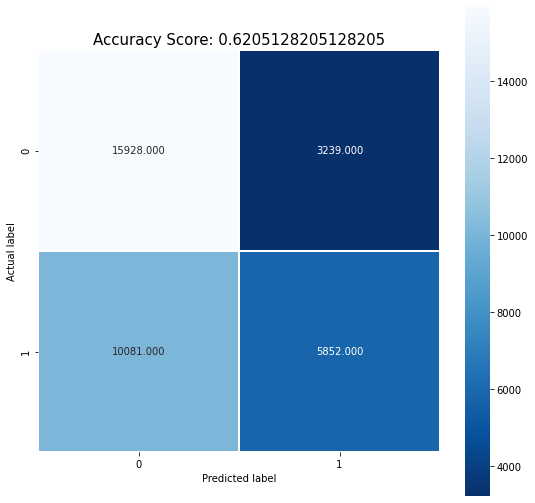

In [15]:



from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns


logisticRegr = LogisticRegression()

logit = logisticRegr.fit(x_train, y_train)
#model = logisticRegr.fit(x_train, y_train)

predictions = logisticRegr.predict(x_test)


# Use score method to get accuracy of model

#print (type(x_test))

score = logisticRegr.score(x_test, y_test)
print(score)

# logistic regression confusion matrix

cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


# load the model


model_name = 'LogisticRegression'
model_file = str(modelFolder) + str(model_name) + '.pkl'
pickle.dump(logit, open(model_file, 'wb'))



# SVC 

0.6051566951566951


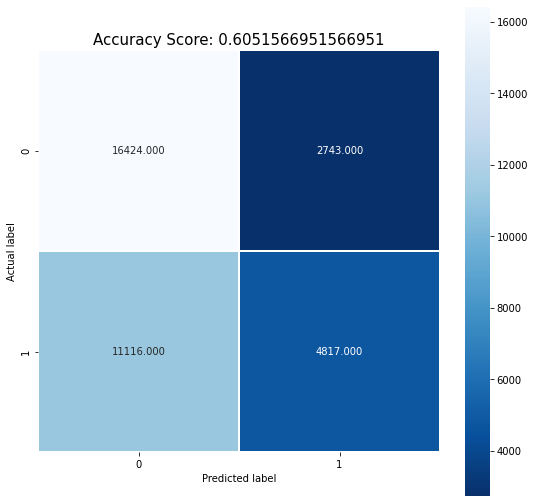

In [16]:
from sklearn import svm

svmClassifier = svm.SVC()

svmFit = svmClassifier.fit(x_train, y_train)

svmPredictions = svmClassifier.predict(x_test)



# get the accuracy
accScore = accuracy_score(y_test, svmPredictions)
print (accScore)


# SVM confusion matrix

cm = metrics.confusion_matrix(y_test, svmPredictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accScore)
plt.title(all_sample_title, size = 15);


# load the model


model_name = 'SVM'
model_file = str(modelFolder) + str(model_name) + '.pkl'
pickle.dump(svmFit, open(model_file, 'wb'))



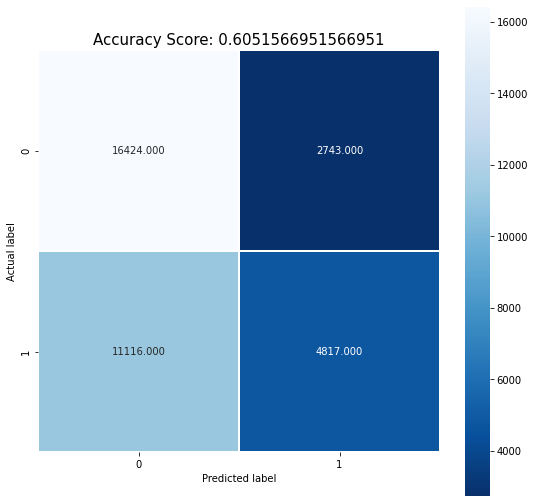

### Calculate Model score - accuracy = total correct predictions / total predictions made * 100

In [16]:
def scores(models, X, y):

    for model in models:
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        auc = roc_auc_score(y, y_pred)
        
        print ("------------------------")
        print ("------------------------")
        print ('')
        print (model)
        print("Accuracy Score: {0:0.2f} %".format(acc * 100))
        print("F1 Score: {0:0.4f}".format(f1))
        print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
        print ('')
        print ("------------------------")
        print ("------------------------")
        
        
        
        cm = metrics.confusion_matrix(y, y_pred)
        
        plt.figure(figsize=(9,9))
        sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        
        all_sample_title = 'Accuracy Score for model : {0}'.format(acc)
        plt.title(all_sample_title, size = 15);
        print ("------------------------")
        
        
        

## Put models in grid along with its parameters



#### SVM, Random Forest, Multilayer perceptron

In [17]:
models = [
    SVC(random_state=5)
    ,RandomForestClassifier(random_state=5),
    MLPClassifier(random_state=5)
]

for model in models: 
    model.fit(x_train, y_train)

    

    
grid_data = [
                # SVM
            [
                {'kernel': ['poly'], 'degree': [1, 2, 3, 4], 'C': [0.1, 1, 10, 100], 'random_state': [5]},
                {'kernel': ['rbf', 'sigmoid'], 'C': [0.1, 1, 10, 100], 'random_state': [5]}
             ],
                    # RandomForestClassifier
                {'n_estimators': [10, 50, 100],
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 10, 50, 100],
                 'min_samples_split': [2, 5, 10],
                 'random_state': [5]
                },
                    # MLPClassifier - Neural Network multi layer perceptron 
                {
                #'hidden_layer_sizes': [10, 50, 100],
                'hidden_layer_sizes': [10, 15],
                'activation': ['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'],
                'max_iter': [200, 400, 800],
                'random_state': [5]
               }
        
                ]

models_grid = list()



## Train the models (in the grid)

In [ ]:
for i in range(3):
    print (i, grid_data[i])
    grid = GridSearchCV(models[i], grid_data[i], scoring='f1').fit(x_train, y_train)
    model = grid.best_estimator_
    models_grid.append(model)
    scores(models_grid, x_test, y_test)

0 [{'kernel': ['poly'], 'degree': [1, 2, 3, 4], 'C': [0.1, 1, 10, 100], 'random_state': [5]}, {'kernel': ['rbf', 'sigmoid'], 'C': [0.1, 1, 10, 100], 'random_state': [5]}]


### Save the models using pickle library, these model (files) will be later used for live trading

In [103]:
val = 1
model_name = 'Start'

for model in models_grid:
    if val == 1:
        model_name = 'SVC'
    elif val == 2:
        model_name = 'RandomForest'
    elif val == 3:
        model_name = 'MultiLayerPerceptron'
        
    val += 1
    print (model, model_name)
    model_file = modelFolder + str(model_name) + '.pkl'
    pickle.dump(model, open(model_file, 'wb'))


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='sigmoid', max_iter=-1, probability=False, random_state=5,
  shrinking=True, tol=0.001, verbose=False) SVC
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=5, verbose=0, warm_start=False) RandomForest
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=15, learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state